## Base Machine Learning Model

In [8]:
import glob
import tifffile
import numpy as np
import lightgbm as lgb
import warnings
import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

warnings.simplefilter('ignore')

In [22]:
train_path =  '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/'
mask_path = '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/mask/'

masks_path = glob.glob(f'{mask_path}/*')
data_path = glob.glob(f'{train_path}/*')
masks_path.sort()
data_path.sort()

In [23]:
print("IMAGES Total:  {}".format(len(data_path)))

IMAGES Total:  2066


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split



path = "/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/"
images_train_path = os.path.join(path,'s2_image')
images_train = sorted(glob.glob(os.path.join(images_train_path, "**/*.tif"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))
mask_train_path = os.path.join(path,'mask')
mask_train = sorted(glob.glob(os.path.join(mask_train_path, "**/*.tif"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_train)))
df_train = pd.DataFrame(columns=['rgb_path','mask_path','dataset'])
df_train['rgb_path'] = images_train
df_train['mask_path'] = mask_train

df_train, df_test = train_test_split(df_train, test_size=0.30, random_state=42)
print("train data: {}".format(len(df_train)))
print("test data: {}".format(len(df_test)))

IMAGES /home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image ### Total:  2066
MASK /home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/mask ### Total:  2066
train data: 1446
test data: 620


'/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/mask/train_mask_479.tif'

In [ ]:
from sklearn.model_selection import train_test_split
X, y, test_size=0.33, random_state=42)

In [31]:
X = []
y = []
g = []

for i, (t, m) in enumerate(zip(df_train['rgb_path'].values, df_train['mask_path'].values)):
    img = tifffile.imread(t).astype(np.float64)
    # img = np.delete(img,[6,7,8],2)
    
    mask = tifffile.imread(m).astype(np.float64)
    # nb_one = len(mask[mask==1])
    # if nb_one==0:
    #     continue
    
    X.append(img.reshape(-1,12))
    # X.append(img.reshape(-1,9))
    y.append(mask.reshape(-1))
    g.append(np.ones_like(mask.reshape(-1))*i)
    
X = np.vstack(X)
y = np.hstack(y)
g = np.hstack(g) 

In [32]:
print("Dataset shape:  {}".format(X.shape))

Dataset shape:  (793498, 12)


In [33]:
lgb_params = {    
    'boosting_type':'gbdt',
    'learning_rate' : 0.1,
    'num_leaves':31,
    'max_depth':-1,
    'random_state':136,
	'n_estimators':100,
	'objective':'binary'
    }

def evaluate_macroF1_lgb(y_true, y_pred):  

    y_pred_label = np.round(y_pred)

    f1 = f1_score(y_true, y_pred_label, average='binary')

    print('f1 score:', f1)

    return ('f1_score', f1, True)

## Make Model

In [34]:
gkfold = GroupKFold(n_splits=4)

models = []

for i, (train_idx, valid_idx) in enumerate(gkfold.split(X, y, g)):
    train_x = X[train_idx]
    train_y = y[train_idx]
    
    val_x = X[valid_idx]
    val_y = y[valid_idx]
    
    m = lgb.LGBMClassifier(**lgb_params)
    m.fit(train_x, train_y, 
         # eval_metric='f1',
         eval_metric= evaluate_macroF1_lgb,
         eval_set=[(val_x, val_y)],
         callbacks=[lgb.log_evaluation(100)])
    
    models.append(m)

[LightGBM] [Info] Number of positive: 53166, number of negative: 541726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 594892, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.089371 -> initscore=-2.321341
[LightGBM] [Info] Start training from score -2.321341
f1 score: 0.0
f1 score: 0.0
f1 score: 0.0
f1 score: 0.0
f1 score: 0.0
f1 score: 0.12896341463414634
f1 score: 0.34925558312655086
f1 score: 0.5763279273917571
f1 score: 0.6441030620383535
f1 score: 0.66554576635954
f1 score: 0.6828675577156744
f1 score: 0.6933126875060487
f1 score: 0.7076407760854453
f1 score: 0.7205324376438391
f1 score: 0.7275903282155005
f1 score: 0.7330597355221158
f1 score: 0.7372262773722628
f1 score: 0.7414473684

In [35]:
models

[LGBMClassifier(objective='binary', random_state=136),
 LGBMClassifier(objective='binary', random_state=136),
 LGBMClassifier(objective='binary', random_state=136),
 LGBMClassifier(objective='binary', random_state=136)]

In [36]:
## Feature Importance

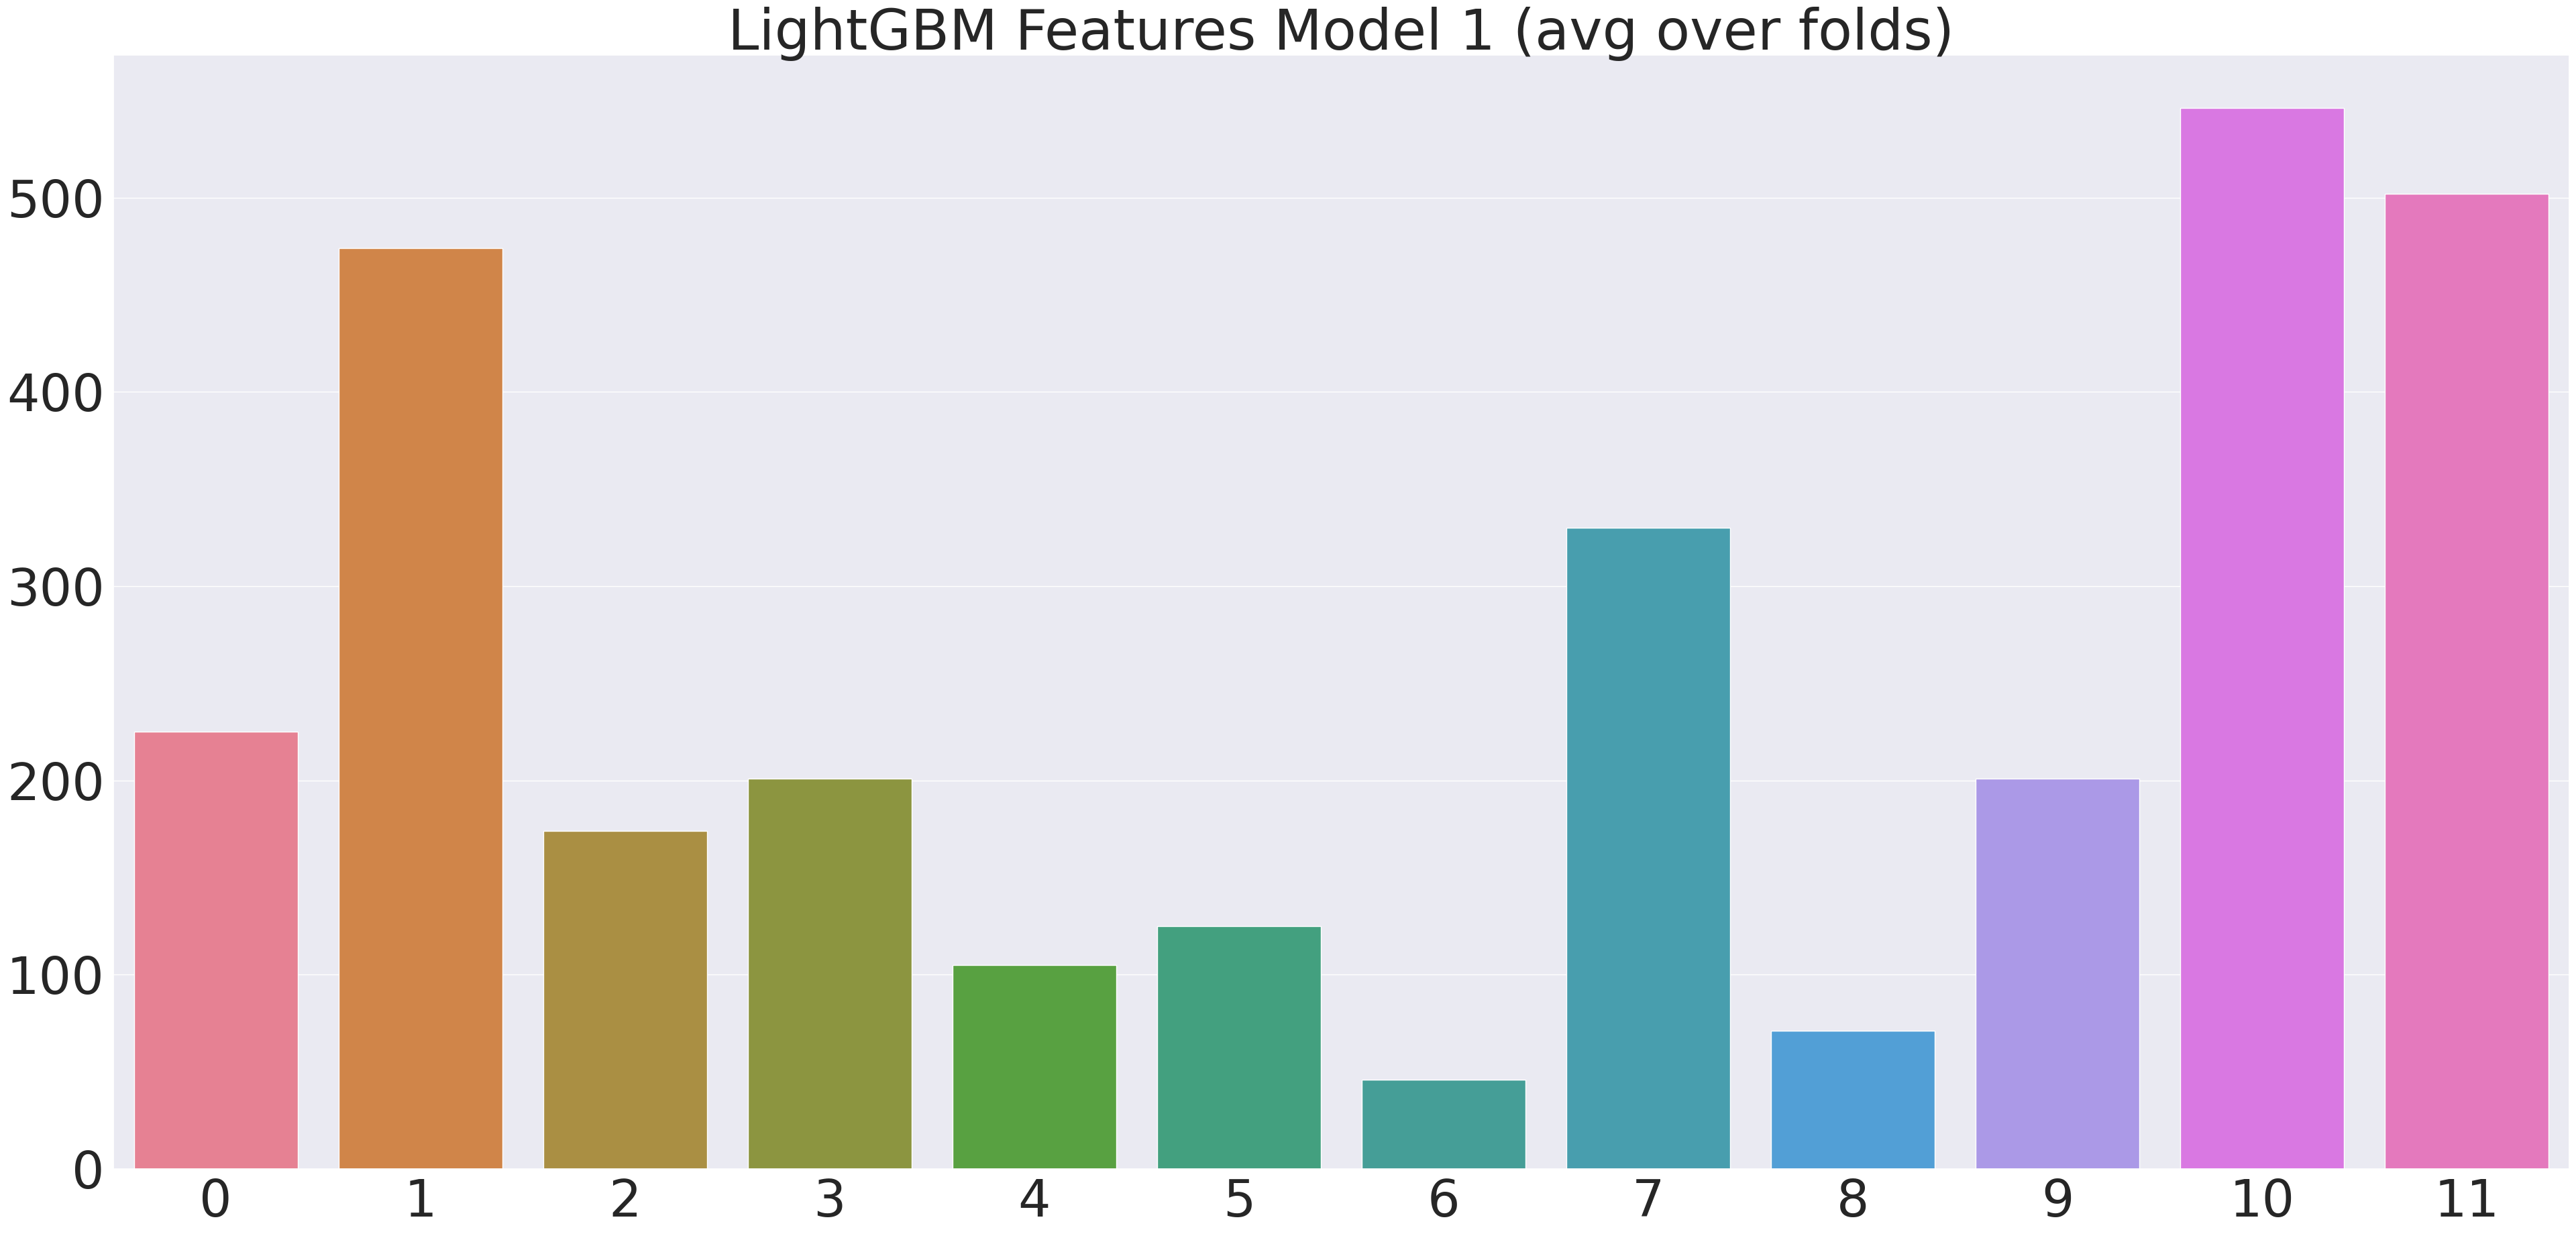

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

df_feature_importance = pd.DataFrame({'Value':models[0].feature_importances_})
df_feature_importance = df_feature_importance.T
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(df_feature_importance)
plt.title('LightGBM Features Model 1 (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances-01.png')
plt.show()

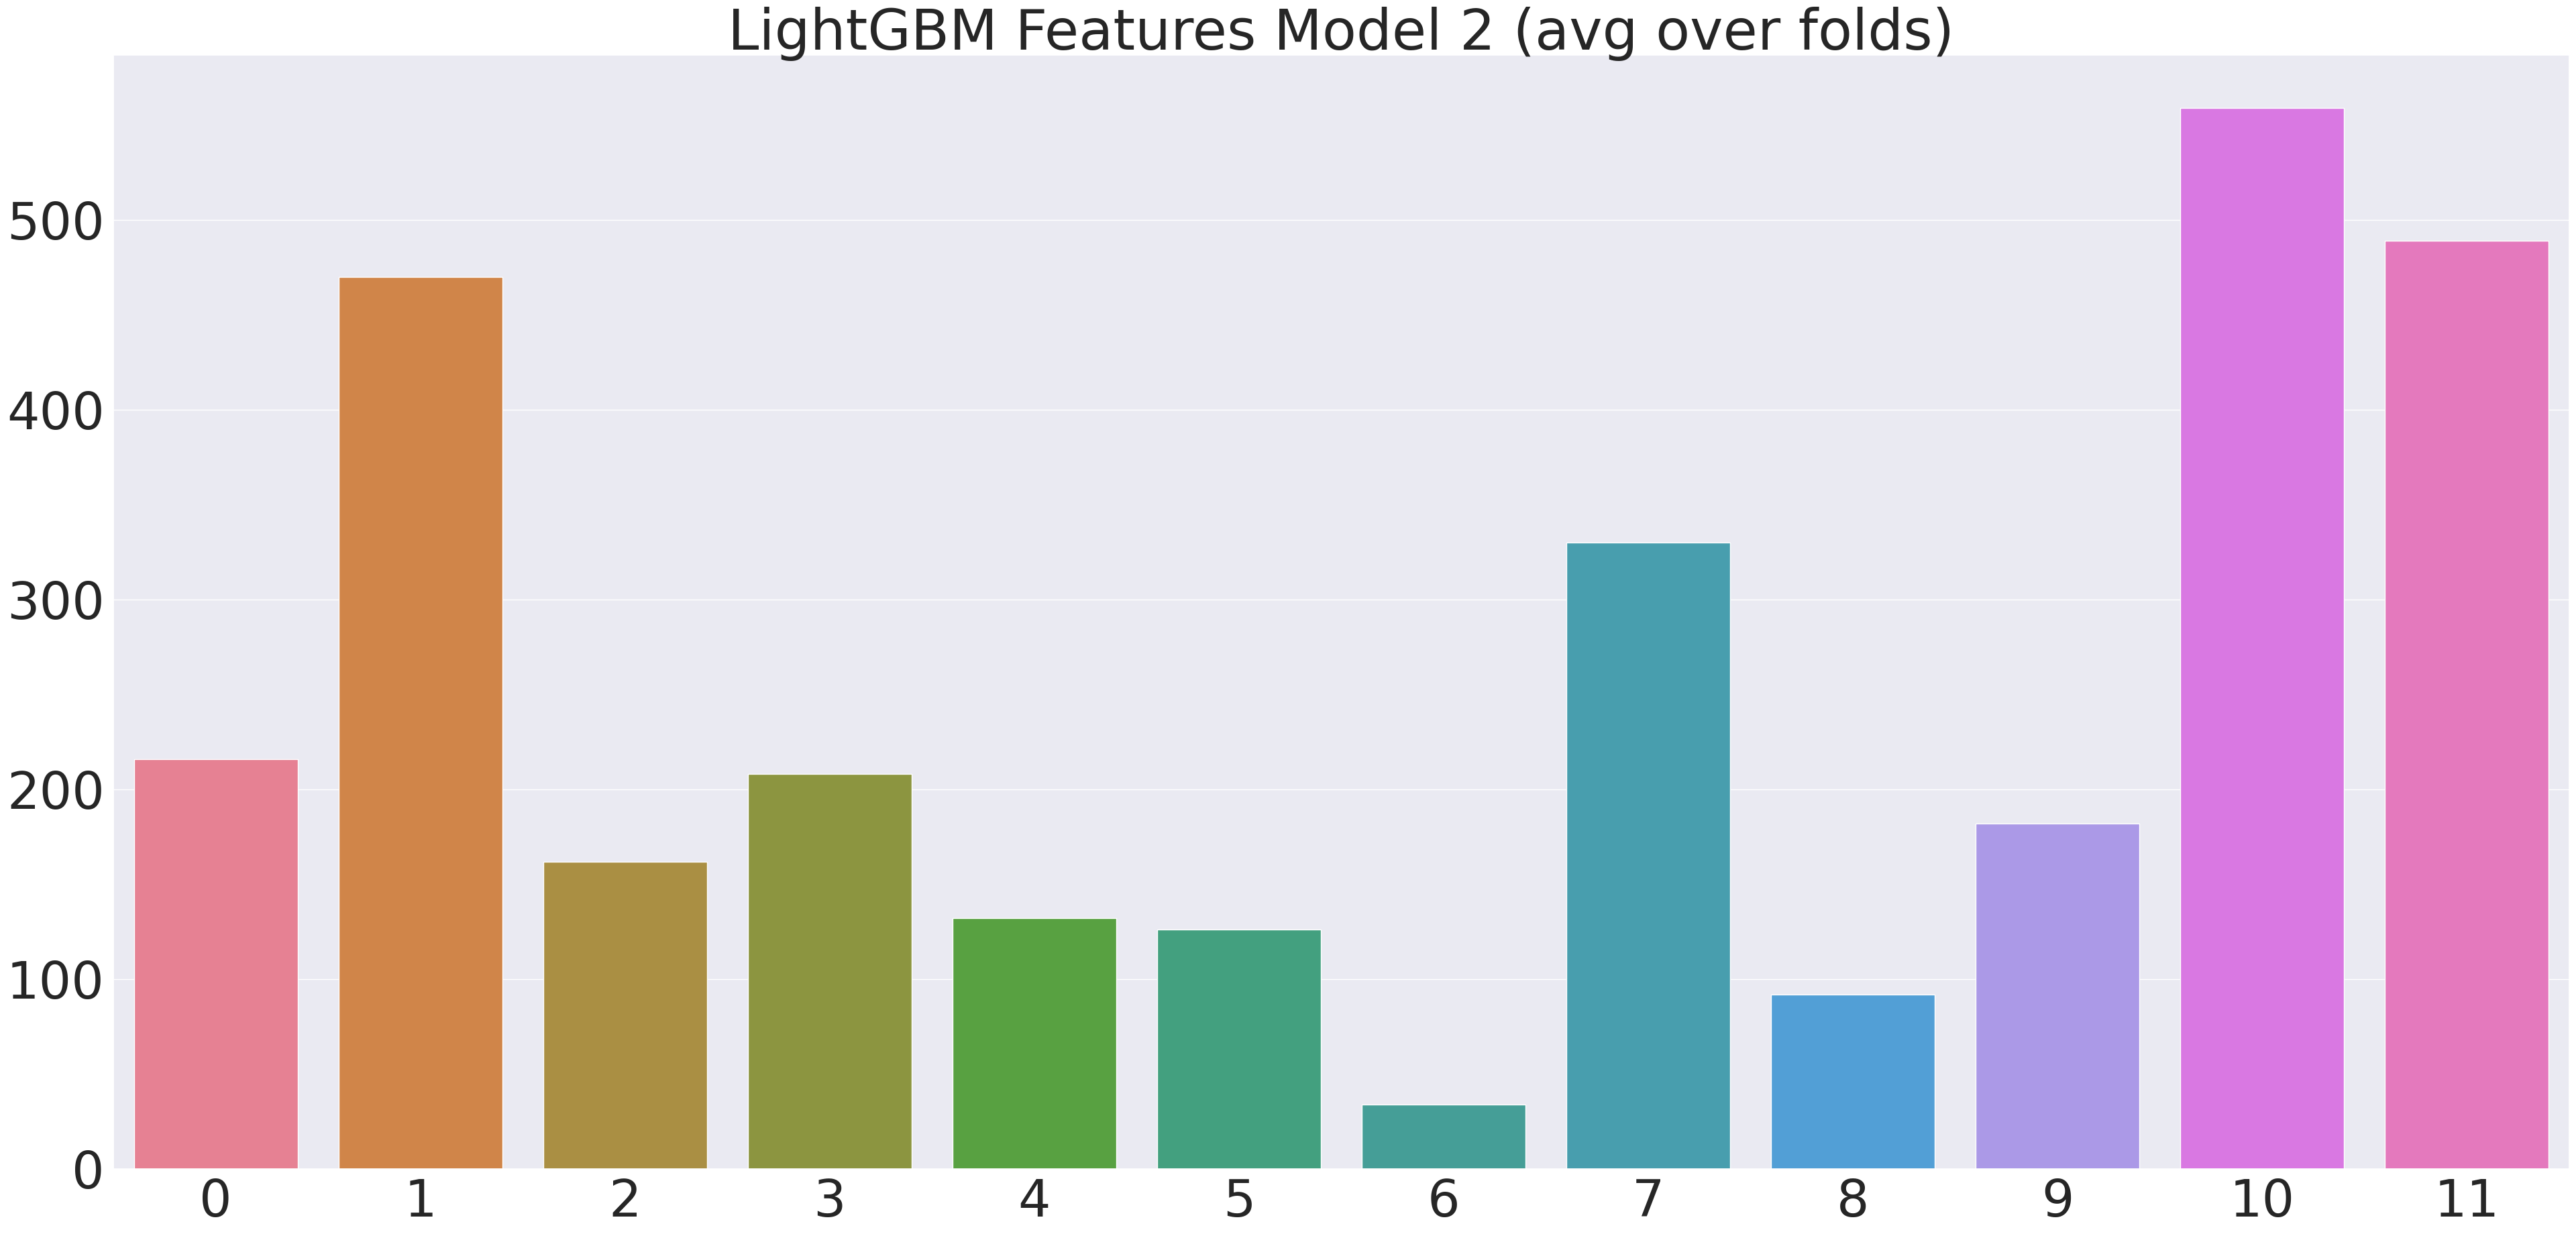

In [38]:
df_feature_importance = pd.DataFrame({'Value':models[1].feature_importances_})
df_feature_importance = df_feature_importance.T
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(df_feature_importance)
plt.title('LightGBM Features Model 2 (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-02.png')
plt.show()

In [73]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

## Model Evaluation


In [90]:
import os
import cv2
if not os.path.isdir('validation'):
    os.mkdir('validation')



for i, (t, m_gt) in tqdm.tqdm(enumerate(zip(df_test['rgb_path'].values, df_test['mask_path'].values))):
    basename = os.path.basename(m_gt)
    basename = basename.replace("tif","png")
    output_file = f'validation/{basename}'
    print(t)
    img = tifffile.imread(t).astype(np.float64)
    print("image shape:", img.shape)
    mask_gt = tifffile.imread(m_gt).astype(np.float64)
    print(mask_gt.shape)

    red = img[:,:,3]
    green = img[:,:,2]
    blue = img[:,:,1]

    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    image = ((rgb_composite_n - rgb_composite_n.min()) / (rgb_composite_n.max() - rgb_composite_n.min())) * 255
    image = image.astype(np.uint8)
    print("rgb_composite_n shape:", img.shape)
    
    X = img.reshape(-1, 12)
    # X = img.reshape(-1, 9) 
    shape_mask = mask_gt.shape
   
    pred = 0
    for model in models:
        pred = model.predict_proba(X) / len(models)
    
    pred_mask = (pred[:,1] > threshold).astype(np.uint8)
    pred_mask = np.argmax(pred, axis=1).astype(np.uint8)
    
    pred_mask = pred_mask.reshape(shape_mask[0], shape_mask[1])
    print(pred_mask.shape)
    final = np.hstack([mask_gt,pred_mask])

    final = cv2.merge((final,final,final))
    final = final * 255
    
    final = np.hstack([image,final])

    cv2.imwrite(output_file, final)
    

28it [00:00, 279.29it/s]

/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_479.tif
image shape: (25, 25, 12)
(25, 25)
rgb_composite_n shape: (25, 25, 12)
(25, 25)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_908.tif
image shape: (23, 22, 12)
(23, 22)
rgb_composite_n shape: (23, 22, 12)
(23, 22)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_341.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_750.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1023.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-pane

90it [00:00, 299.95it/s]

/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1329.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1801.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1402.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1479.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1729.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-

152it [00:00, 300.78it/s]

(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_106.tif
image shape: (25, 25, 12)
(25, 25)
rgb_composite_n shape: (25, 25, 12)
(25, 25)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1267.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_153.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1658.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1892.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune

214it [00:00, 301.41it/s]

(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1710.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_860.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_700.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_604.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1341.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-

275it [00:00, 290.02it/s]

(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_271.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_949.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1953.tif
image shape: (25, 25, 12)
(25, 25)
rgb_composite_n shape: (25, 25, 12)
(25, 25)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1223.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1106.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune

338it [00:01, 300.48it/s]

image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_571.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1144.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1180.tif
image shape: (25, 25, 12)
(25, 25)
rgb_composite_n shape: (25, 25, 12)
(25, 25)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_252.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_840.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n sh

402it [00:01, 308.73it/s]

(23, 22)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_731.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1149.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1270.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1328.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_650.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune

465it [00:01, 309.99it/s]

/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1516.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1637.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_2053.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_533.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1565.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-p

529it [00:01, 310.40it/s]

(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1948.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_469.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1935.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1918.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1306.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafun

593it [00:01, 312.49it/s]

(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_686.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_369.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_785.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1242.tif
image shape: (24, 24, 12)
(24, 24)
rgb_composite_n shape: (24, 24, 12)
(24, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_591.tif
image shape: (24, 23, 12)
(24, 23)
rgb_composite_n shape: (24, 23, 12)
(24, 23)
/home/sebastien/Documents/projects/solafune-s

620it [00:02, 303.90it/s]

(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1430.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_567.tif
image shape: (23, 24, 12)
(23, 24)
rgb_composite_n shape: (23, 24, 12)
(23, 24)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_1453.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_649.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/train_s2_image_868.tif
image shape: (23, 23, 12)
(23, 23)
rgb_composite_n shape: (23, 23, 12)
(23, 23)
/home/sebastien/Documents/projects/solafune-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


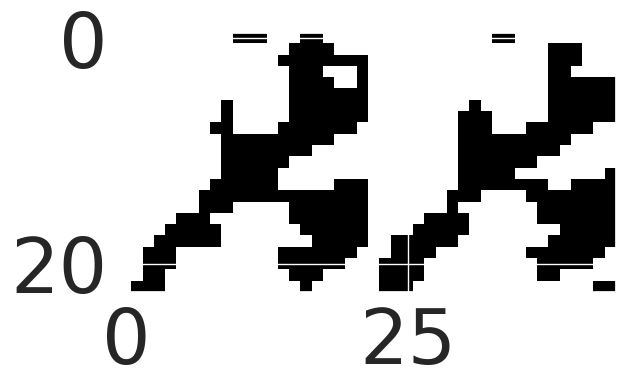

In [81]:
plt.imshow(final)

# Prediction on sample data

In [68]:
test_path =  '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/evaluation/'
test_mask_path = '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/sample/'


masks = glob.glob(f'{test_mask_path}/*')
tests = glob.glob(f'{test_path}/*')
masks.sort()
tests.sort()

In [69]:
print("IMAGES Total:  {}".format(len(tests)))

IMAGES Total:  2066


In [70]:
import os
if not os.path.isdir('output'):
    os.mkdir('output')

In [71]:
threshold = 0.1

for i, (m, t) in tqdm.tqdm(enumerate(zip(masks, tests))):
    basename = os.path.basename(m)
    output_file = f'output/{basename}'
    
    img = tifffile.imread(t).astype(np.float64)
    mask = tifffile.imread(m).astype(np.float64)

    # img = np.delete(img,[6,7,8],2)
    
    X = img.reshape(-1, 12)
    # X = img.reshape(-1, 9) 
    shape_mask = mask.shape
   
    pred = 0
    for model in models:
        pred = model.predict_proba(X) / len(models)
    
    pred_mask = (pred[:,1] > threshold).astype(np.uint8)
    # pred_mask = np.argmax(pred, axis=1).astype(np.uint8)
    
    pred_mask = pred_mask.reshape(shape_mask[0], shape_mask[1])
    
    tifffile.imwrite(output_file, pred_mask)
 

2066it [00:06, 299.96it/s]


# Output directory into zip file

In [72]:
import zipfile

output_folder_path = 'output'
with zipfile.ZipFile('output.zip', 'w') as zipf:
    for root, dirs, files in os.walk(output_folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), file)